---
title: Blochwave Algorithm
authors: [gvarnavides]
date: 2025-01-27
---

In [1]:
import abtem
import abtem.bloch
import ase

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation

abtem.config.set({"dask.lazy":False});

In [2]:
Si3N4_crystal = ase.Atoms(
    "Si6N8",
    scaled_positions=[
        (0.82495, 0.59387, 0.75),
        (0.23108, 0.82495, 0.25),
        (0.59387, 0.76892, 0.25),
        (0.40614, 0.23108, 0.75),
        (0.76892, 0.17505, 0.75),
        (0.17505, 0.40613, 0.25),
        
        (0.66667, 0.33334, 0.75),
        (0.33334, 0.66667, 0.25),
        (0.66986, 0.70066, 0.75),
        (0.96920, 0.66986, 0.25),
        (0.70066, 0.03081, 0.25),
        (0.29934, 0.96919, 0.75),
        (0.33015, 0.29934, 0.25),
        (0.03081, 0.33014, 0.75),
    ],
    cell=[7.6045, 7.6045, 2.9052, 90, 90, 120],
    pbc=True
)
Si3N4_orthorhombic = abtem.orthogonalize_cell(Si3N4_crystal)

In [53]:
g_max = 4
sg_max = 0.1
thermal_sigma = 0.1
energy = 300e3

structure_factor = abtem.bloch.StructureFactor(
    Si3N4_orthorhombic,
    g_max=g_max,
    thermal_sigma=thermal_sigma,
    parametrization="lobato"
)

bloch_waves = abtem.bloch.BlochWaves(
    structure_factor=structure_factor,
    energy=energy,
    sg_max=sg_max,
)

kinematical_diffraction_pattern = bloch_waves.get_kinematical_diffraction_pattern()

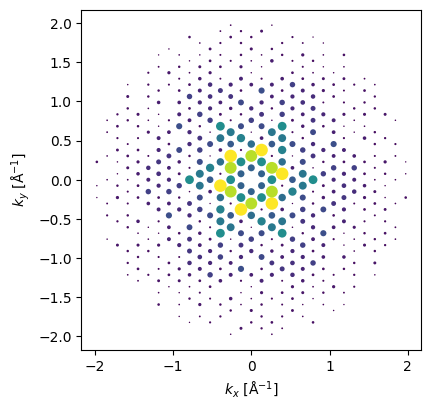

In [39]:
#| label: app:blochwave_kinematical
kinematical_diffraction_pattern.block_direct(
).show(
    scale=0.08,
    power=0.5,
    annotations=False,
    figsize=(4,4)
);

In [106]:
cell_thickness = Si3N4_orthorhombic.cell[2,2]
cell_thicknesses = np.arange(cell_thickness*50,cell_thickness*400,cell_thickness*100)

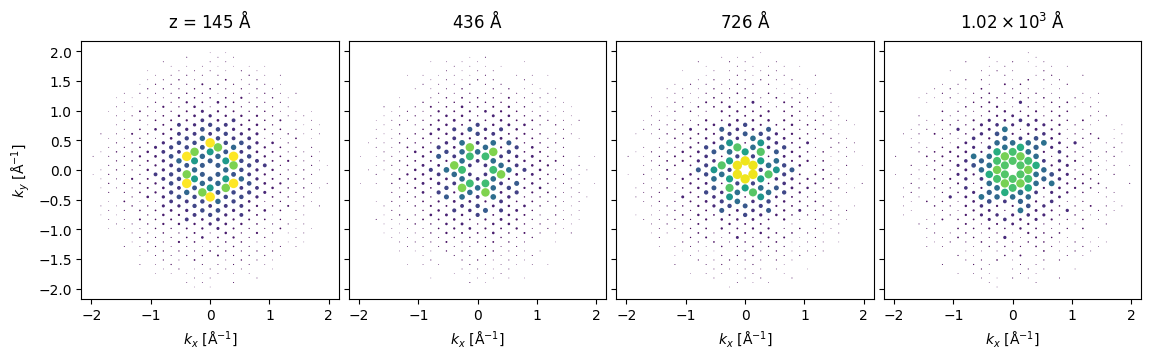

In [107]:
#| label: app:blochwave_thickness

bloch_waves.calculate_diffraction_patterns(
    cell_thicknesses,
    lazy=False,
).block_direct(
).show(
    scale=0.08,
    power=0.5,
    explode=True,
    annotations=False,
    common_color_scale=True,
    figsize=(12,4)
);

## Tilted Crystal Electron Diffraction

In [108]:
x_angles = np.linspace(0,120e-3,4)
y_angles = np.linspace(120e-3,0,4)
xy_angles = np.dstack(np.meshgrid(x_angles,y_angles,indexing='ij')).reshape((-1,2))

orientation_matrices = Rotation.from_euler('xy',xy_angles).as_matrix()

bloch_matrices = [
    abtem.bloch.BlochWaves(
        structure_factor=structure_factor,
        energy=energy,
        sg_max=sg_max,
        orientation_matrix=orientation,
    ) for orientation in orientation_matrices
]

dps = [
    bloch.calculate_diffraction_patterns(
        thicknesses=np.array([cell_thicknesses[0]]),
        lazy=False,
    ).block_direct(
    ) for bloch in bloch_matrices
]


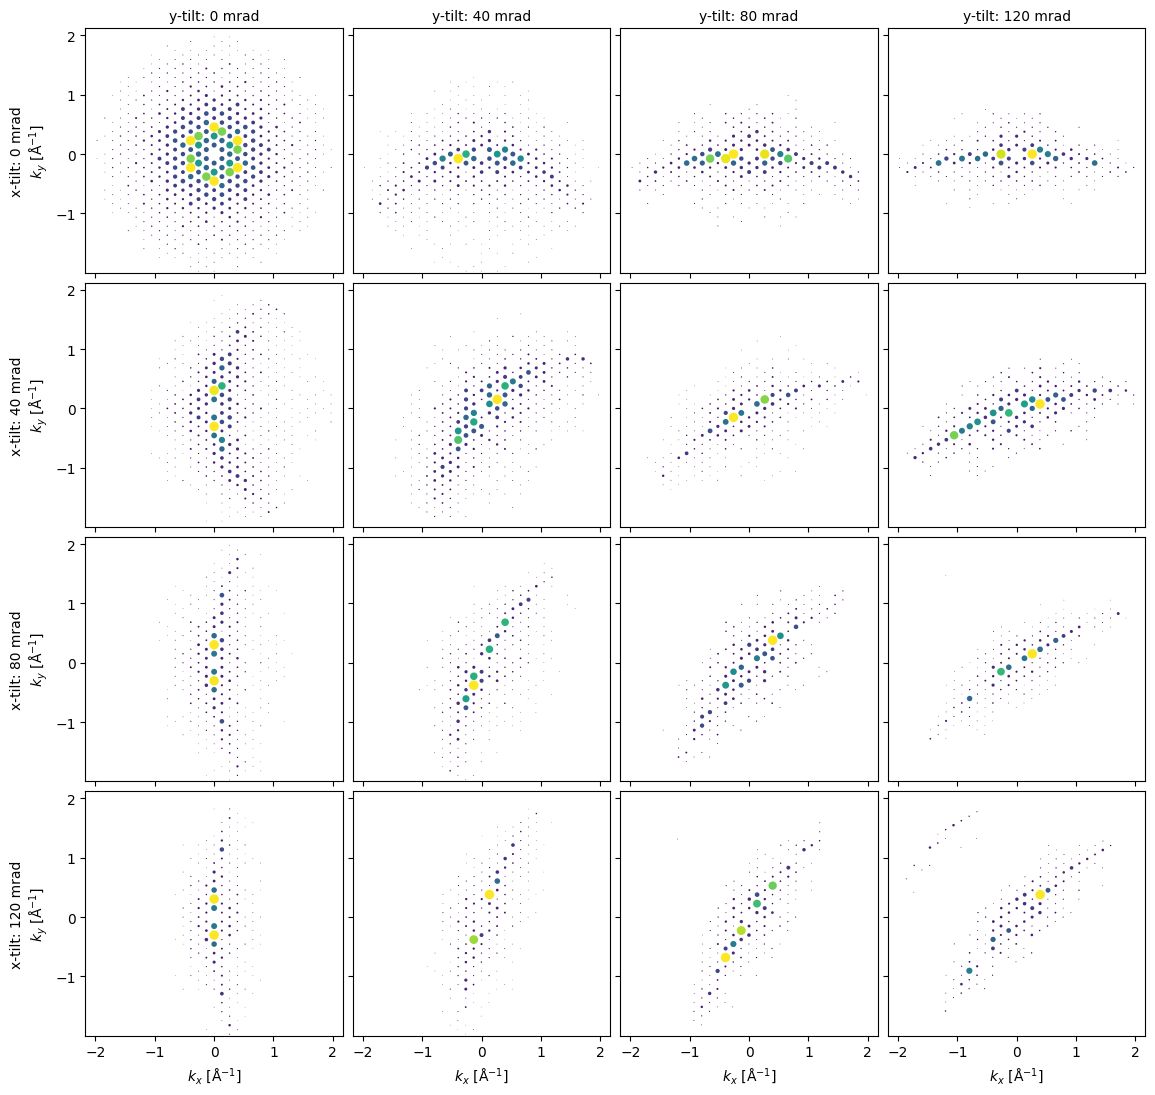

In [109]:
#| label: app:blochwave_tilted

fig = plt.figure(figsize=(12,12))
axes = abtem.visualize.axes_grid.AxesGrid(
    fig=fig,
    ncols=4,
    nrows=4,
)._axes

y_indices = np.tile(np.arange(4),4)
x_indices = np.repeat(np.arange(4),4)

for ax, dp, x_ind, y_ind in zip(axes.ravel(),dps,x_indices, y_indices):
    dp.show(
        scale=0.08,
        power=0.5,
        annotations=False,
        ax=ax
    )
    if x_ind == 0:
        label = ax.get_ylabel()
        ax.set_ylabel(f"x-tilt: {x_angles[3-y_ind]*1e3:.0f} mrad\n"+label)
    if y_ind == 3:
        ax.set_title(f"y-tilt: {y_angles[3-x_ind]*1e3:.0f} mrad",fontsize=10)